Alttaki kodda bize verilen verisetini pandas ile okuyoruz.

In [27]:
import pandas as pd

train_data = pd.read_csv('cure_the_princess_train.csv')
val_data = pd.read_csv('cure_the_princess_validation.csv')
test_data = pd.read_csv('cure_the_princess_test.csv')

Alttaki kodda ise önceden okuduğumuz verisetini numpy ile okuyoruz üzerinde işlem yapabilmek için.

In [28]:
import numpy as np

train_data_np = train_data.to_numpy()
val_data_np = val_data.to_numpy()
test_data_np = test_data.to_numpy()

GPU kullanabilmesi için bütün verileri device ile gpu'ya aktarıyoruz.
En son sütundaki cured değerini labellara aktarıyoruz.
İlk 13 sütundaki değerleri ise inputlara aktarıyoruz.

In [29]:
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
print(device)

train_inputs = torch.from_numpy(train_data_np[:, :13]).float().to(device)
train_labels = torch.from_numpy(train_data_np[:, 13]).long().to(device)

val_inputs = torch.from_numpy(val_data_np[:, :13]).float().to(device)
val_labels = torch.from_numpy(val_data_np[:, 13]).long().to(device)

test_inputs = torch.from_numpy(test_data_np[:, :13]).float().to(device)
test_labels = torch.from_numpy(test_data_np[:, 13]).long().to(device)


cuda:0


Alttaki kodda input ve label verilerimizi dataloader ile yüklüyoruz. Batch size 16 bizim için ideal.

In [30]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(train_inputs, train_labels)
val_dataset = TensorDataset(val_inputs, val_labels)
test_dataset = TensorDataset(test_inputs, test_labels)

batch_size = 16

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Burada Multi Layer Perceptron sınıfını oluşturduk. Manual seed içine öğrenci numaramı koydum.
Burada ilk hidden layerda 100 nöron var.
İkinci hidden layerda 50 nöron var.
Output layerda ise 1 nöron var, cured değerinin çıktı olması için.

Hidden layerlarda Relu fonksiyonu kullandık.
Output layerda ise sigmoid kullandık.

Sonrasında Binary Cross Entropy Loss kullandık çünkü çıktımız bir binary değer.
Learning rate olarak 0.001 verdim bu değerde iyi bir grafik çıkıyor.

In [31]:
import torch.nn as nn

torch.manual_seed(190401055)

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.hidden_layer_1 = nn.Linear(13, 100)
        self.hidden_layer_2 = nn.Linear(100, 50)
        self.output_layer = nn.Linear(50, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.hidden_layer_1(x))
        x = self.relu(self.hidden_layer_2(x))
        x = self.sigmoid(self.output_layer(x))
        return x

model = MLP().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

Altta modelimizi eğitiyoruz. Epoch olarak 2000 verdim. 
Patience değeri olarak ise 25 verdim.
Sonrasında en iyi modeli kaydediyoruz.

In [32]:
train_losses = []
val_losses = []
num_epochs = 2000
patience = 25
best_val_loss = np.inf
patience_counter = 0
best_model = None

for epoch in range(num_epochs):
    train_loss = 0.0
    model.train()
    for inputs, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1).float())
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    train_loss /= len(train_dataloader.dataset)
    train_losses.append(train_loss)
    
    val_loss = 0.0
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1).float())
            val_loss += loss.item() * inputs.size(0)
        val_loss /= len(val_dataloader.dataset)
        val_losses.append(val_loss)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping after {epoch + 1} epochs')
                break

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Patience: {patience_counter}')

torch.save(best_model, 'best_model.pt')


Epoch 1/2000, Train Loss: 0.6750, Val Loss: 0.6441, Patience: 0
Epoch 2/2000, Train Loss: 0.6251, Val Loss: 0.6048, Patience: 0
Epoch 3/2000, Train Loss: 0.5918, Val Loss: 0.5738, Patience: 0
Epoch 4/2000, Train Loss: 0.5643, Val Loss: 0.5464, Patience: 0
Epoch 5/2000, Train Loss: 0.5397, Val Loss: 0.5221, Patience: 0
Epoch 6/2000, Train Loss: 0.5169, Val Loss: 0.4984, Patience: 0
Epoch 7/2000, Train Loss: 0.4951, Val Loss: 0.4746, Patience: 0
Epoch 8/2000, Train Loss: 0.4742, Val Loss: 0.4522, Patience: 0
Epoch 9/2000, Train Loss: 0.4543, Val Loss: 0.4309, Patience: 0
Epoch 10/2000, Train Loss: 0.4354, Val Loss: 0.4110, Patience: 0
Epoch 11/2000, Train Loss: 0.4179, Val Loss: 0.3930, Patience: 0
Epoch 12/2000, Train Loss: 0.4015, Val Loss: 0.3762, Patience: 0
Epoch 13/2000, Train Loss: 0.3863, Val Loss: 0.3603, Patience: 0
Epoch 14/2000, Train Loss: 0.3725, Val Loss: 0.3459, Patience: 0
Epoch 15/2000, Train Loss: 0.3598, Val Loss: 0.3326, Patience: 0
Epoch 16/2000, Train Loss: 0.3481,

Oluşturduğumuz verinin grafiğini seaborn ile oluşturuyoruz.

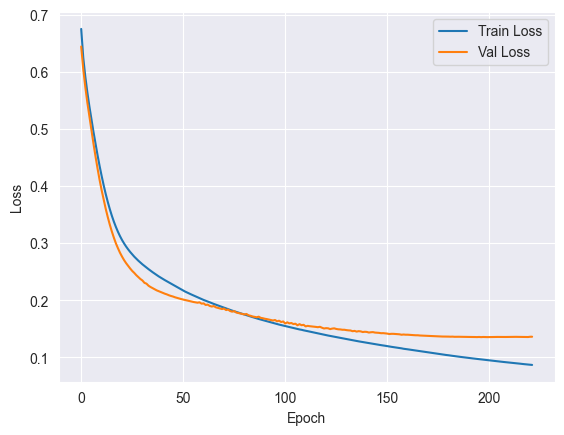

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('darkgrid')
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


Burada sklearn kütüphanesi ile modelimizin accuracy, f1, precision ve recall değerlerini hesaplıyoruz.

In [34]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

model.load_state_dict(torch.load('best_model.pt'))

test_predictions = []
test_labels = []
model.eval()
with torch.no_grad():
    for inputs, labels in test_dataloader:
        outputs = model(inputs)
        predicted = torch.round(outputs)
        test_predictions.extend(predicted.detach().cpu().numpy())
        test_labels.extend(labels.detach().cpu().numpy())

accuracy = accuracy_score(test_labels, test_predictions)
f1 = f1_score(test_labels, test_predictions)
precision = precision_score(test_labels, test_predictions)
recall = recall_score(test_labels, test_predictions)

print(f'Accuracy: {accuracy:.4f}')
print(f'F1 score: {f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')

Accuracy: 0.9443
F1 score: 0.9436
Precision: 0.9600
Recall: 0.9278


Alttaki kodda modelin overfit etmesi için early stopping kodunu kaldırdım.

Epoch 1/2000, Train Loss: 0.6750, Val Loss: 0.6441
Epoch 2/2000, Train Loss: 0.6251, Val Loss: 0.6048
Epoch 3/2000, Train Loss: 0.5918, Val Loss: 0.5738
Epoch 4/2000, Train Loss: 0.5643, Val Loss: 0.5464
Epoch 5/2000, Train Loss: 0.5397, Val Loss: 0.5221
Epoch 6/2000, Train Loss: 0.5169, Val Loss: 0.4984
Epoch 7/2000, Train Loss: 0.4951, Val Loss: 0.4746
Epoch 8/2000, Train Loss: 0.4742, Val Loss: 0.4522
Epoch 9/2000, Train Loss: 0.4543, Val Loss: 0.4309
Epoch 10/2000, Train Loss: 0.4354, Val Loss: 0.4110
Epoch 11/2000, Train Loss: 0.4179, Val Loss: 0.3930
Epoch 12/2000, Train Loss: 0.4015, Val Loss: 0.3762
Epoch 13/2000, Train Loss: 0.3863, Val Loss: 0.3603
Epoch 14/2000, Train Loss: 0.3725, Val Loss: 0.3459
Epoch 15/2000, Train Loss: 0.3598, Val Loss: 0.3326
Epoch 16/2000, Train Loss: 0.3481, Val Loss: 0.3206
Epoch 17/2000, Train Loss: 0.3377, Val Loss: 0.3097
Epoch 18/2000, Train Loss: 0.3283, Val Loss: 0.2997
Epoch 19/2000, Train Loss: 0.3199, Val Loss: 0.2912
Epoch 20/2000, Train 

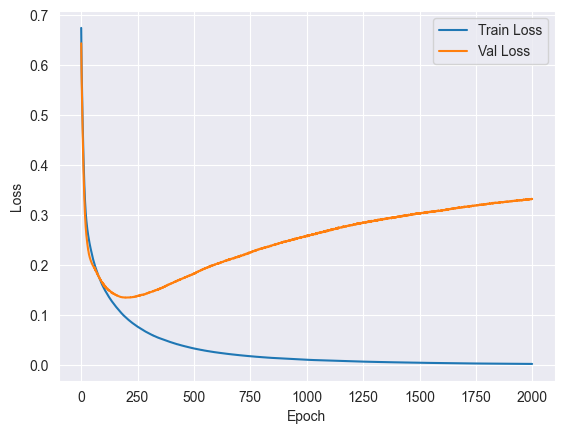

In [35]:
import torch.nn as nn

torch.manual_seed(190401055)

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.hidden_layer_1 = nn.Linear(13, 100)
        self.hidden_layer_2 = nn.Linear(100, 50)
        self.output_layer = nn.Linear(50, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.hidden_layer_1(x))
        x = self.relu(self.hidden_layer_2(x))
        x = self.sigmoid(self.output_layer(x))
        return x

model = MLP().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

train_losses = []
val_losses = []
num_epochs = 2000
best_val_loss = np.inf

for epoch in range(num_epochs):
    train_loss = 0.0
    model.train()
    for inputs, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1).float())
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    train_loss /= len(train_dataloader.dataset)
    train_losses.append(train_loss)
    
    val_loss = 0.0
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1).float())
            val_loss += loss.item() * inputs.size(0)
        val_loss /= len(val_dataloader.dataset)
        val_losses.append(val_loss)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    torch.save(model.state_dict(), "worst_model.pt")

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('darkgrid')
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

